# W207 - Final Project
### **Topic**: Sentiment Analysis of Customer Reviews Using Text Classification on the [Yelp Dataset](https://www.yelp.com/dataset)
#### **Team Members**: Michael Drexler, Mohammed Elzubeir, Jonathan Hsiao, Andrei Lupan

**Objectives**

*   Analyze Yelp review data for potential to build a ML tool for sentiment containted therein.
*   Utilize a variety of models to determin the most efficient one to predict "stars" ratings with the highest degree of accuracy
* One determined, fine-tune the classification model

**Motivation:**
1. Yelps reviews contain a broad range customer sentiment about various businesses. As such, they are a useful resource to attempt to disect written commentary for fundamental opinions about customer service experiences.
2. We want to discover the best way of doing so with the ML tools at our disposal.


**Data:**
The Yelp dataset is a subset of our businesses, reviews, and user data for use in connection with academic research. Available as JSON files, use it to teach students about databases, to learn NLP, or for sample production data while you learn how to make mobile apps.



## Data Ingestion

In [ ]:
!pip install wordcloud
!pip install pydot
!pip install graphviz
!pip install contractions
!pip install lime

In [ ]:
# Standard Libraries
import os
import re
import json
import random
import warnings
from collections import Counter
from itertools import product

# Silence warnings and TensorFlow logs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Numerical and Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import resample

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model, backend as K
from tensorflow.keras.layers import (
    Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Embedding, LSTM, GRU, Dropout,
    LayerNormalization, Input, MultiHeadAttention, SpatialDropout1D,
    Bidirectional, BatchNormalization, Concatenate
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

# Transformers (Hugging Face)
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    classification_report, roc_curve, auc
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# NLP and Text Processing
import nltk
from nltk.corpus import stopwords
import contractions

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import Image, display, SVG
from lime.lime_text import LimeTextExplainer

# Other Utilities
import kagglehub
import tqdm

In [ ]:
# In order to export .pngs for upload into ppt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the dataset directly from Kaggle
path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")  # This downloads and extracts the dataset
print("Path to dataset files:", path)

# Check all files in the directory
for root, dirs, files in os.walk(path):
    for file in files:
        if file == "yelp_academic_dataset_review.json":
            dataset_path = os.path.join(root, file)
            print("Dataset Path:", dataset_path)

# Verify the file exists
if os.path.exists(dataset_path):
    print("Dataset found successfully!")
else:
    print("Error: Dataset not found.")

100%|██████████| 4.07G/4.07G [00:39<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4
Dataset Path: /root/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4/yelp_academic_dataset_review.json
Dataset found successfully!


#### Whole Dataset

In [ ]:
# Create pandas dataframe for prelim analysis on whole dataset
with open(dataset_path, "r", encoding="utf-8") as file:
    data = [json.loads(line) for line in file]  # Load each line as a JSON object
review_df = pd.DataFrame(data)

#### Sample Dataset ()

In [ ]:
# Initialize list for sampling
sample_data = []
sample_size = 300000

# Random seed for reproducibility
random.seed(1)

# Process dataset in chunks
chunks = pd.read_json(dataset_path, lines=True, chunksize=100000)

# Reservoir sampling for large datasets
total_records = 0
for chunk in chunks:
    chunk_data = chunk.to_dict(orient='records')
    total_records += len(chunk_data)

    for record in chunk_data:
        if len(sample_data) < sample_size:
            sample_data.append(record)
        else:
            j = random.randint(0, total_records - 1)
            if j < sample_size:
                sample_data[j] = record

# Verify the loaded data
print(f"Loaded {len(sample_data)} records.")

Loaded 300000 records.


In [ ]:
# Display first record
for i, record in enumerate(sample_data[:1]):
    for key, value in list(record.items()):
        print(f"  {key}: {value}")

  review_id: I_60tqEoAky1I9GF87r0hA
  user_id: TEPd-wezKjJuUbxTLeKzAw
  business_id: nvYfBJC84m8JLlKDRotbbA
  stars: 3
  useful: 1
  funny: 0
  cool: 0
  text: Sometimes I like to break my routine of breakfast sandwiches and hoagies, and sometimes I'd rather bring the same routine someplace different. Enter Frank & Eddie's, a small corner deli located obscurely on Colwell Lane. This place has everything I want when I make my regular trips to Deli on 4th, often at lower prices - a bacon egg and cheese here is a dollar cheaper.
But it's just not as good. The rolls are decent but have torn and collapsed beneath the weight of my cheesesteak meat before, which is a big red flag. The turkey hoagie was tasty and sizeable, but just not quite as tasty as Deli on 4th. And the location is way out of the way for me. Why drive a mile when I can walk three blocks?
This place is fine, but Deli on 4th is just better, plain and simple.
  date: 2011-02-09 18:45:56


## Exploratory Data Analysis (EDA) I

### Whole Dataset

#### Compute Basic Statistics

In [ ]:
# Compute average rating & coolness, and distribution of each on full dataset

full_ratings = review_df['stars']
full_coolness = review_df['cool'] # For potential alternative analysis

full_average_rating = np.mean(full_ratings)
print(f"\nAverage Rating: {full_average_rating:.2f}")

full_average_coolness = np.mean(full_coolness)
print(f"\nAverage Coolness: {full_average_coolness:.2f}")

# Count occurrences of each star rating
full_rating_distribution = Counter(full_ratings)
print("\n\nFull Rating Distribution:")
for full_stars, full_count in sorted(full_rating_distribution.items()):
    print(f"{full_stars} stars: {full_count} reviews ({full_count/len(review_df['stars'])*100:.2f}%)")

full_cool_labels = []

for j in full_coolness:
  if j == 0:
    full_cool_labels.append(0) #negative
  else:
    full_cool_labels.append(1) #positive

# Count occurrences of each coolness rating
full_coolness_distribution = Counter(full_cool_labels)
print("\n\nFull Coolness Distribution:")
for full_coolness, full_count in sorted(full_coolness_distribution.items()):
    print(f"{full_coolness} coolness: {full_count} reviews ({full_count/len(review_df['stars'])*100:.2f}%)")


Average Rating: 3.75

Average Coolness: 0.50


Full Rating Distribution:
1.0 stars: 1069561 reviews (15.30%)
2.0 stars: 544240 reviews (7.79%)
3.0 stars: 691934 reviews (9.90%)
4.0 stars: 1452918 reviews (20.78%)
5.0 stars: 3231627 reviews (46.23%)


Full Coolness Distribution:
0 coolness: 5377964 reviews (76.93%)
1 coolness: 1612316 reviews (23.07%)


#### Piecharts


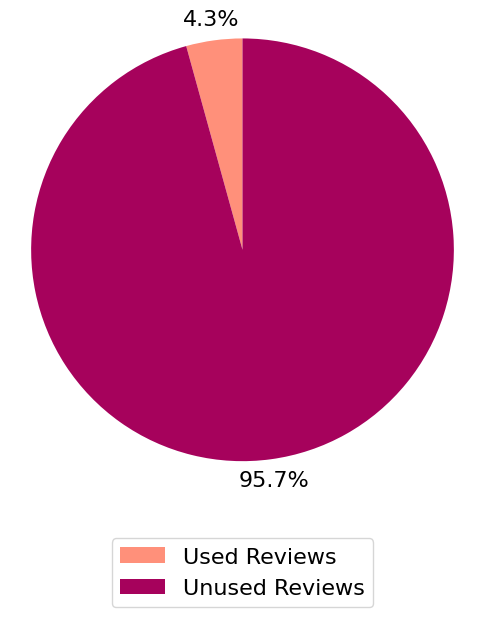

In [ ]:
sample_counts = [sample_size, total_records - sample_size]

labels = ['Used Reviews', 'Unused Reviews']

#colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']   # Palette for conform with ppt preso
colors = ['#FF907A','#A6025C']

# Chart
plt.figure(figsize=(6, 6))
plt.pie(sample_counts, autopct='%1.1f%%', pctdistance=1.1,startangle=90, colors=colors, textprops={'fontsize': 16})
plt.legend(
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # Adjust position
    fontsize=16,
    title_fontsize=14,
    ncol=1,
    frameon=True,  # Show the legend box
    fancybox=True,
)
plt.axis('equal')

file_path = '/content/drive/MyDrive/Colab Notebooks/used_notused_distribution.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

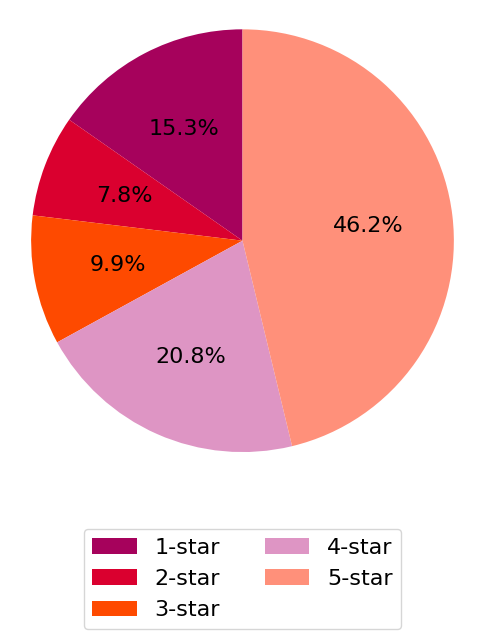

In [ ]:
# Build pie chart of ratings cuts from full Yelp data
star_counts = review_df['stars'].value_counts().sort_index()

labels = [f"{int(star)}-star" for star in star_counts.index]

colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']  # Palette for conform with ppt preso

# Chart
plt.figure(figsize=(6, 6))
plt.pie(star_counts, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 16})
plt.legend(
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # Adjust position
    fontsize=16,
    title_fontsize=14,
    ncol=2,
    frameon=True,  # Show the legend box
    fancybox=True,
)
plt.axis('equal')

file_path = '/content/drive/MyDrive/Colab Notebooks/full_stars_distribution.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()


### Sample Dataset

#### Compute Basic Statistics on the Sample Dataset

In [ ]:
# Compute average rating
average_rating = np.mean(ratings)
print(f"\nAverage Rating: {average_rating:.2f}")

# Count occurrences of each star rating
rating_distribution = Counter(ratings)
print("\nRating Distribution:")
for stars, count in sorted(rating_distribution.items()):
    print(f"{stars} stars: {count} reviews")

label_distribution = Counter(labels)
print("\nLabel Distribution:")
for label, count in sorted(label_distribution.items()):
    print(f"{label} labels: {count} reviews")


Average Rating: 3.75

Rating Distribution:
1 stars: 46057 reviews
2 stars: 23339 reviews
3 stars: 29699 reviews
4 stars: 62438 reviews
5 stars: 138467 reviews

Label Distribution:
0 labels: 99095 reviews
1 labels: 200905 reviews


#### Plot Distribution

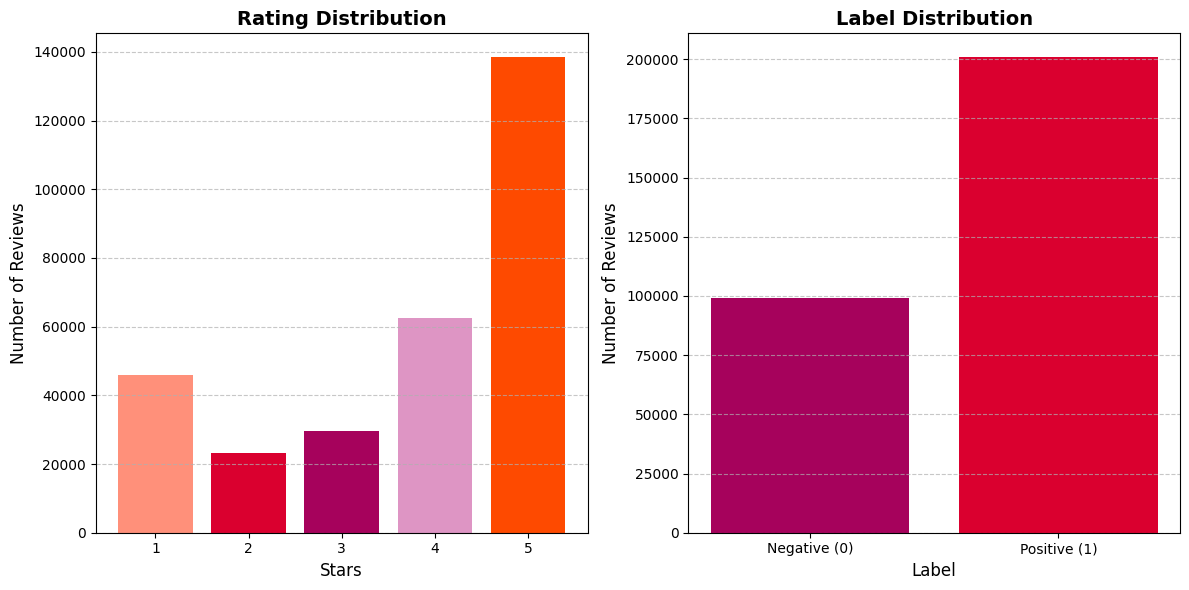

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define colors for each plot
rating_colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']  # Colors for stars
label_colors = ['#A6025C', '#DA002F']  # Colors for labels

# Plot Rating Distribution
axes[0].bar(
    rating_distribution.keys(),
    rating_distribution.values(),
    color=rating_colors,
)
axes[0].set_title("Rating Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Stars", fontsize=12)
axes[0].set_ylabel("Number of Reviews", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot Label Distribution
axes[1].bar(
    ["Negative (0)", "Positive (1)"],
    [label_distribution[0], label_distribution[1]],
    color=label_colors,
)
axes[1].set_title("Label Distribution", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Label", fontsize=12)
axes[1].set_ylabel("Number of Reviews", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show the combined plot
plt.tight_layout()

file_path = '/content/drive/MyDrive/Colab Notebooks/sample_distribution.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()


### Feature Selection and Feature Engineering

#### Reviews 1, 2, 3, 4 & 5

In [ ]:
## We are only interested in the text and stars key-value pairs (coolness - for potential future analysis)

# Extract review text and ratings and coolness
reviews = [record['text'] for record in sample_data]
ratings = [record['stars'] for record in sample_data]
coolness = [record['cool'] for record in sample_data]

# Generate the labels based on the rating score. 1-3 negative & 4-5 positive
labels = []

# Generate cool_labels based on cool value. If cool = 0 negative & cool > 0 positive
cool_labels = []

for i in ratings:
  if i in [1,2,3]:
    labels.append(0) #negative
  else:
    labels.append(1) #positive

for j in coolness:
  if j == 0:
    cool_labels.append(0) #negative
  else:
    cool_labels.append(1) #positive

# Print the lenghs of reviews, ratings, and labels
print("\nRatings Shape:", len(ratings))
print("Reviews Shape:", len(reviews))
print("Labels Shape:", len(labels))
print("\n\nCoolness Shape", len(coolness))
print("Cool Labels Shape:", len(cool_labels))


Ratings Shape: 300000
Reviews Shape: 300000
Labels Shape: 300000


Coolness Shape 300000
Cool Labels Shape: 300000


#### Reviews 1, 2, _, 4 & 5

In [ ]:
# Experimenting with removing the Neutral reviews

# Extract review text, ratings, and coolness
filtered_reviews = [record['text'] for record in sample_data]
filtered_ratings = [record['stars'] for record in sample_data]
filtered_coolness = [record['cool'] for record in sample_data]

# Filter out reviews, ratings, labels, and coolness for star rating 3
filtered_reviews = [filtered_reviews[idx] for idx, rating in enumerate(filtered_ratings) if rating != 3]
filtered_ratings = [rating for rating in filtered_ratings if rating != 3]
filtered_coolness = [filtered_coolness[idx] for idx, rating in enumerate(filtered_ratings) if rating != 3]

# Generate filtered labels directly during filtering
filtered_labels = [
    0 if rating in [1, 2] else 1 for rating in filtered_ratings
]

# Generate filtered cool_labels based on filtered coolness
filtered_cool_labels = [0 if cool == 0 else 1 for cool in filtered_coolness]

# Print the lengths of filtered reviews, ratings, and labels
print("\nFiltered Ratings Shape:", len(filtered_ratings))
print("Filtered Reviews Shape:", len(filtered_reviews))
print("Filtered Labels Shape:", len(filtered_labels))
print("\n\nFiltered Coolness Shape:", len(filtered_coolness))
print("Filtered Cool Labels Shape:", len(filtered_cool_labels))


Filtered Ratings Shape: 270301
Filtered Reviews Shape: 270301
Filtered Labels Shape: 270301


Filtered Coolness Shape: 270301
Filtered Cool Labels Shape: 270301


### Balance the data

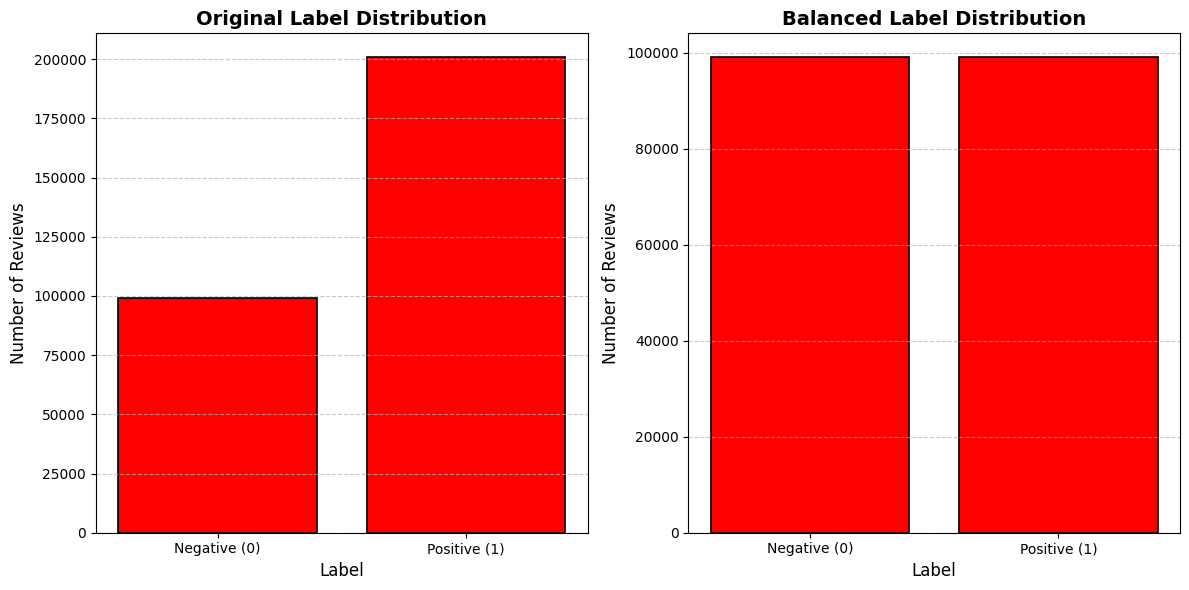

In [ ]:
# Create a DataFrame from our reviews and labels
data = pd.DataFrame({'reviews': reviews, 'labels': labels})

# Separate majority and minority classes
minority_class = data[data['labels'] == 0]
majority_class = data[data['labels'] == 1]

# Balance the dataset using undersampling
majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=1)

# Combine the balanced dataset
balanced_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=1)

# Extract reviews and labels
balanced_reviews = balanced_data['reviews'].tolist()
balanced_labels = balanced_data['labels'].tolist()

# Compute distributions for the original and balanced data
rating_distribution = data['labels'].value_counts().sort_index().to_dict()
balanced_label_distribution = balanced_data['labels'].value_counts().sort_index().to_dict()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set common style options
common_style = {
    "color": "red",
    "edgecolor": "black",
    "linewidth": 1.2,
}

# Plot original label distribution
axes[0].bar(
    ["Negative (0)", "Positive (1)"],
    [rating_distribution.get(0, 0), rating_distribution.get(1, 0)],
    **common_style
)
axes[0].set_title("Original Label Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Label", fontsize=12)
axes[0].set_ylabel("Number of Reviews", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot balanced label distribution
axes[1].bar(
    ["Negative (0)", "Positive (1)"],
    [balanced_label_distribution.get(0, 0), balanced_label_distribution.get(1, 0)],
    **common_style
)
axes[1].set_title("Balanced Label Distribution", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Label", fontsize=12)
axes[1].set_ylabel("Number of Reviews", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

## Train test split

In [ ]:
X = np.array(reviews)
y = np.array(labels)
X_filtered = np.array(filtered_reviews)
y_filtered = np.array(filtered_labels)
X_balanced = np.array(balanced_reviews)
y_balanced = np.array(balanced_labels)

# Create training, validation, and test datasets using a 60/20/20 split
# Create training (60%) and temporary (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42)
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y_filtered, train_size=0.6, random_state=42)
X_train_balanced, X_temp_balanced, y_train_balanced, y_temp_balanced = train_test_split(X_balanced, y_balanced, train_size=0.6, random_state=42)

# Split temporary set into test (20%) and validation (20%) sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_test_filtered, X_val_filtered, y_test_filtered, y_val_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)
X_test_balanced, X_val_balanced, y_test_balanced, y_val_balanced = train_test_split(X_temp_balanced, y_temp_balanced, test_size=0.5, random_state=42)

# Verify the splits
print(f"Sample from X_train: {X_train[:1]}")
print(f"Sample from X_test: {X_test[:1]}")
print(f"Sample from X_val: {X_val[:1]}")

print(f"Sample from y_train: {y_train[:1]}")
print(f"Sample from y_test: {y_test[:1]}")
print(f"Sample from y_val: {y_val[:1]}")

## Exploratory Data Analysis (EDA) II

### Word Frequency

In [ ]:
# Tokenize review text and count word frequencies
word_counter = Counter()
for review in X_train:
    expanded_review = contractions.fix(review) # Eliminate contractions
    words = re.findall(r'\b\w+\b', expanded_review.lower())  # Extract words ignoring case
    word_counter.update(words)

# Display the 10 most common words
print("\nMost Common Words in X_train:\n")
for word, count in word_counter.most_common(10):
    print(f"{word}: {count} times")


Most Common Words in X_train:

the: 945476 times
and: 674249 times
i: 562764 times
a: 484924 times
to: 459393 times
was: 358902 times
is: 296014 times
it: 275901 times
of: 268474 times
not: 229628 times


Minimum positive review length: 10
Minimum negative review length: 1
Maximum positive review length: 5000
Maximum negative review length: 5000
Mean positive review length: 501.69629672693446
Mean negative review length: 696.8393435470609


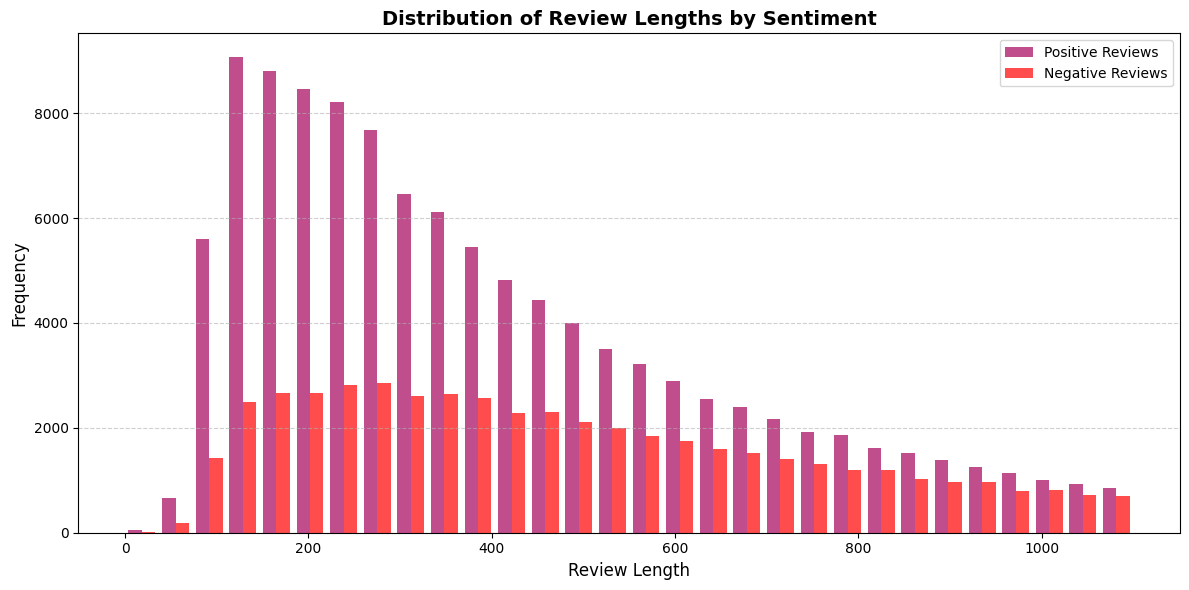

In [ ]:
# What are the minimum, maximum, and mean lengths of positive and negative reviews?
p_review = [len(review) for review, label in zip(X_train, y_train) if label == 1]
n_review = [len(review) for review, label in zip(X_train, y_train) if label == 0]
p_review_min = np.min(p_review)
n_review_min = np.min(n_review)
p_review_max = np.max(p_review)
n_review_max = np.max(n_review)
p_review_mean = np.mean(p_review)
n_review_mean = np.mean(n_review)

print('Minimum positive review length:', p_review_min)
print('Minimum negative review length:', n_review_min)
print('Maximum positive review length:', p_review_max)
print('Maximum negative review length:', n_review_max)
print('Mean positive review length:', p_review_mean)
print('Mean negative review length:', n_review_mean)


# Create a histogram to visualize the distribution of positive and negative review lengths
plt.figure(figsize=(12, 6))
plt.hist(
    [p_review, n_review],
    bins=30,
    color=['#A6025C', 'red'],
    label=['Positive Reviews', 'Negative Reviews'],
    range=(0, 1100),
    alpha=0.7,  # Add slight transparency for overlap clarity
)


# Add labels, title, and legend
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Review Lengths by Sentiment', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add gridlines for better readability

# Show the plot
plt.tight_layout()

file_path = '/content/drive/MyDrive/Colab Notebooks/review_length_sentiment.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

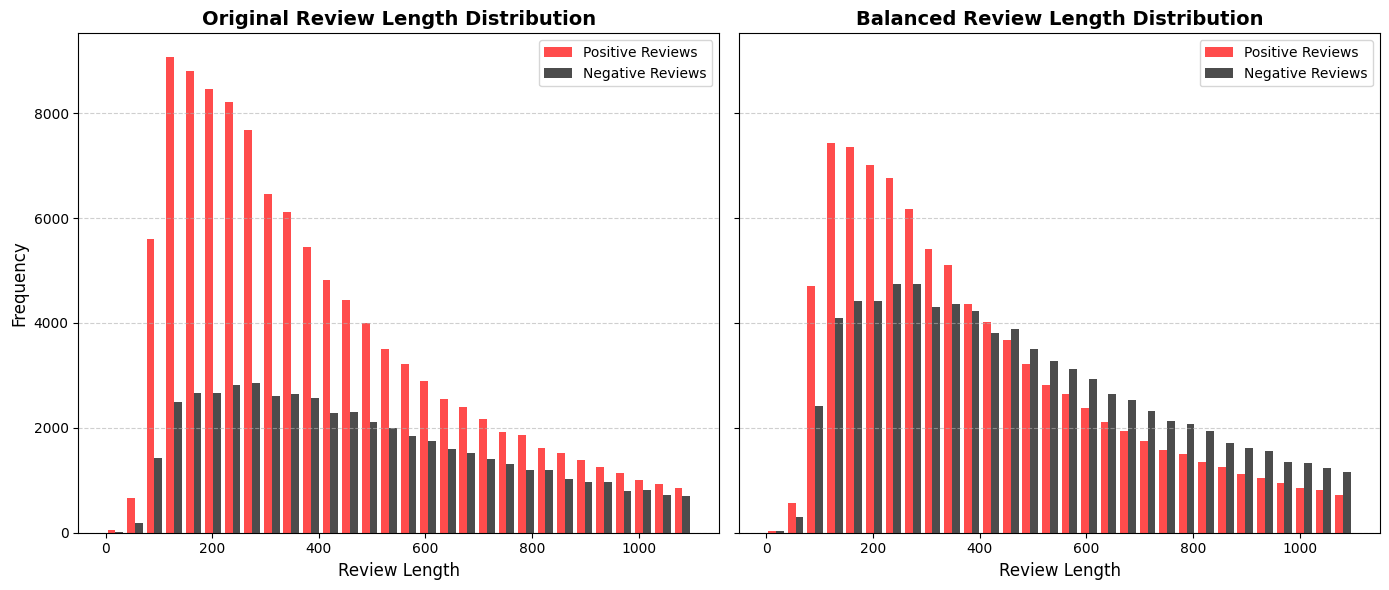

In [ ]:
# Calculate review lengths for the original dataset
original_positive_review_lengths = [len(review) for review, label in zip(X_train, y_train) if label == 1]
original_negative_review_lengths = [len(review) for review, label in zip(X_train, y_train) if label == 0]

# Calculate review lengths for the balanced dataset
balanced_positive_review_lengths = [len(review) for review, label in zip(balanced_reviews, balanced_labels) if label == 1]
balanced_negative_review_lengths = [len(review) for review, label in zip(balanced_reviews, balanced_labels) if label == 0]

# Create subplots for original and balanced distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot original review lengths distribution
axes[0].hist(
    [original_positive_review_lengths, original_negative_review_lengths],
    bins=30,
    color=['red', 'black'],
    label=['Positive Reviews', 'Negative Reviews'],
    range=(0, 1100),
    alpha=0.7
)
axes[0].set_title('Original Review Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Review Length', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Plot balanced review lengths distribution
axes[1].hist(
    [balanced_positive_review_lengths, balanced_negative_review_lengths],
    bins=30,
    color=['red', 'black'],
    label=['Positive Reviews', 'Negative Reviews'],
    range=(0, 1100),
    alpha=0.7
)
axes[1].set_title('Balanced Review Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Review Length', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Separate positive and negative reviews based on their labels
positive_reviews = [review for review, label in zip(X_train, y_train) if label == 1]
negative_reviews = [review for review, label in zip(X_train, y_train) if label == 0]

# Tokenize and count word frequencies
def get_word_frequencies(reviews):
    word_counter = Counter()
    for review in reviews:
        if isinstance(review, str):  # Ensure review is a string
            expanded_review = contractions.fix(review) # Eliminate contractions
            words = re.findall(r'\b\w+\b', expanded_review.lower())  # Tokenize and lower case
            word_counter.update(words)
    return word_counter

positive_word_counts = get_word_frequencies(positive_reviews)
negative_word_counts = get_word_frequencies(negative_reviews)

# Display the top 10 words for each
print("Top 10 Words in Positive Reviews:")
print(positive_word_counts.most_common(10))

print("\nTop 10 Words in Negative Reviews:")
print(negative_word_counts.most_common(10))


Top 10 Words in Positive Reviews:
[('the', 559721), ('and', 432788), ('i', 315494), ('a', 298128), ('to', 247476), ('was', 196892), ('is', 195001), ('of', 162833), ('it', 157120), ('for', 130632)]

Top 10 Words in Negative Reviews:
[('the', 385755), ('i', 247270), ('and', 241461), ('to', 211917), ('a', 186796), ('was', 162010), ('not', 130269), ('it', 118781), ('of', 105641), ('is', 101013)]


In [ ]:
# Convert sklearn stop words to a set for fast lookup
stop_words = set(ENGLISH_STOP_WORDS)
custom_stop_words = {'food', 'place', 'restaurant', 'service', 't', 's', 'time', 'order', 'did', 'just'}  # Add domain-specific words
stop_words.update(custom_stop_words)


# Tokenize, remove stop words, and count word frequencies
def get_filtered_word_frequencies(reviews):
    word_counter = Counter()
    for review in reviews:
        if isinstance(review, str):  # Ensure review is a string
            expanded_review = contractions.fix(review) # Eliminate contractions
            words = re.findall(r'\b\w+\b', expanded_review.lower())  # Tokenize and lower case
            filtered_words = [word for word in words if word not in stop_words]
            word_counter.update(filtered_words)
    return word_counter

# Recompute word frequencies for positive and negative reviews
positive_word_counts_filtered = get_filtered_word_frequencies(positive_reviews)
negative_word_counts_filtered = get_filtered_word_frequencies(negative_reviews)

# Display the top 10 words for each
print("Top 10 Words in Positive Reviews (Filtered):")
print(positive_word_counts_filtered.most_common(10))

print("\nTop 10 Words in Negative Reviews (Filtered):")
print(negative_word_counts_filtered.most_common(10))

Top 10 Words in Positive Reviews (Filtered):
[('great', 67261), ('good', 56578), ('like', 30665), ('really', 26980), ('best', 25997), ('delicious', 23758), ('love', 22442), ('friendly', 22383), ('nice', 22112), ('amazing', 20743)]

Top 10 Words in Negative Reviews (Filtered):
[('good', 28325), ('like', 25540), ('got', 15525), ('ordered', 14902), ('said', 14780), ('really', 14409), ('told', 13168), ('came', 12677), ('great', 12449), ('went', 11851)]


### Word CLouds

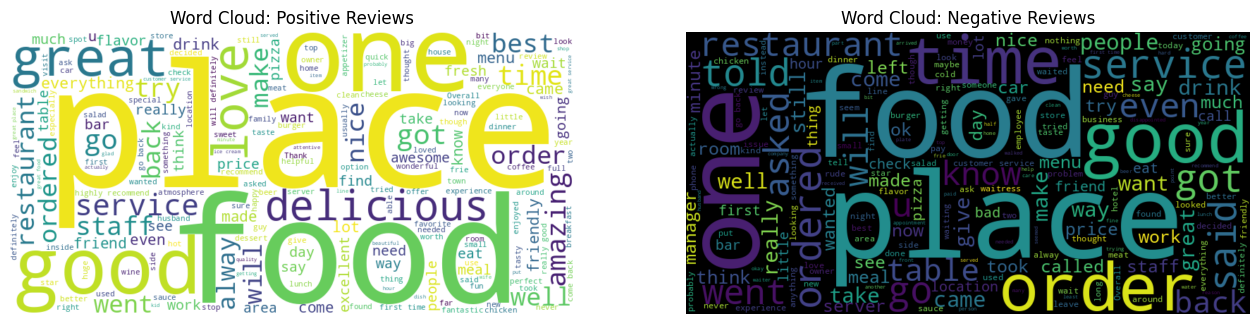

In [ ]:

# Generate word clouds for positive and negative reviews
# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color="black").generate(" ".join(negative_reviews))

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Positive Reviews")

# Negative reviews word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Negative Reviews")

plt.show()


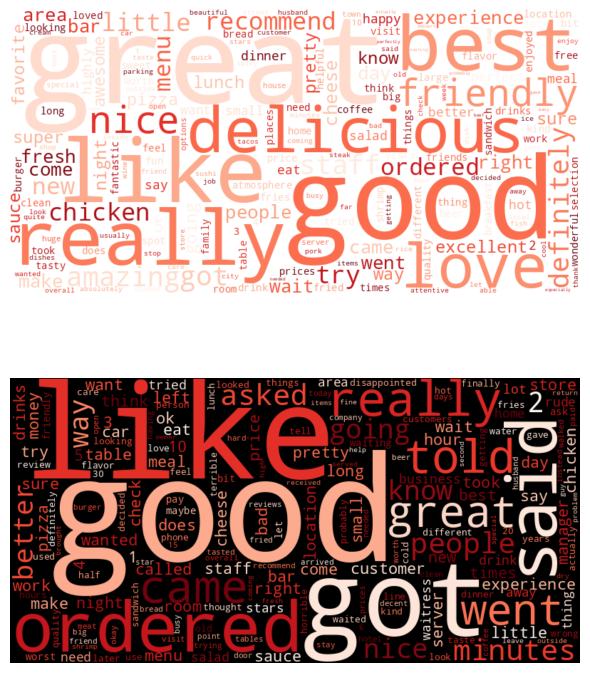

In [ ]:
# Generate word clouds with red words
positive_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Reds"  # Red words on a white background
).generate_from_frequencies(positive_word_counts_filtered)

negative_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="black",
    colormap="Reds"  # Red words on a black background
).generate_from_frequencies(negative_word_counts_filtered)

# Plot the word clouds
plt.figure(figsize=(6, 8))

# Positive reviews word cloud
plt.subplot(2, 1, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.title("Word Cloud: Positive Reviews (Filtered)", fontsize=16, fontweight="bold", color="red")

# Negative reviews word cloud
plt.subplot(2, 1, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.title("Word Cloud: Negative Reviews (Filtered)", fontsize=16, fontweight="bold", color="red")

plt.subplots_adjust(hspace=0.2)  # Adjust the vertical space between subplots (smaller value = less space)

plt.tight_layout()

file_path = '/content/drive/MyDrive/Colab Notebooks/wordclouds.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()


### Sense Check

In [ ]:
# Sense check: Do words in wordcloud associate with intuitive
# List of target words
target_words = ['great', 'terrible', 'amazing', 'delicious', 'disgusting', 'horrible']

# Define a function to count target words
def count_target_words(tokens, target_words):
    token_counts = Counter(tokens)  # Count all tokens
    return {word: token_counts[word] for word in target_words}

word_counts = {word: {0: 0, 1: 0} for word in target_words}

# Process each review and update counts
for review, label in zip(X_train, y_train):
    tokens = review.lower().split()  # Tokenize and lowercase
    counts = count_target_words(tokens, target_words)
    for word, count in counts.items():
        word_counts[word][label] += count

total_reviews = {0: sum(1 for y in y_train if y == 0), 1: sum(1 for y in y_train if y == 1)}

# Normalize counts to percentages
word_percentages = {
    word: {
        0: (counts[0] / total_reviews[0]) * 100 if total_reviews[0] > 0 else 0,
        1: (counts[1] / total_reviews[1]) * 100 if total_reviews[1] > 0 else 0
    }
    for word, counts in word_counts.items()
}

# Convert percentages to a DataFrame for easier viewing
word_perc_df = pd.DataFrame(word_percentages).T
word_perc_df.columns = ['Negative (%)', 'Positive (%)']
word_perc_df.index.name = 'Target Word'

# Display the table
print(word_perc_df)

             Negative (%)  Positive (%)
Target Word                            
great           14.317118     44.895230
terrible         3.715201      0.237528
amazing          1.723357      8.664779
delicious        1.817328      8.772746
disgusting       0.825600      0.020763
horrible         3.879650      0.184375


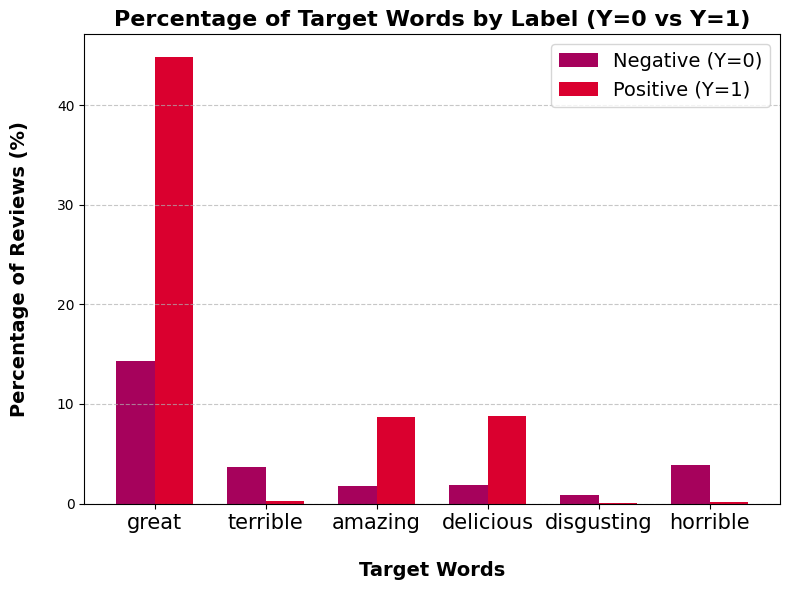

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract data for plotting
words = word_perc_df.index
perc_0 = word_perc_df['Negative (%)']  # Adjust column name
perc_1 = word_perc_df['Positive (%)']  # Adjust column name
x = np.arange(len(words))  # X-axis positions for words

# Bar width
width = 0.35
#rating_colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']
# Plot bars for percentages of Y=0 and Y=1
bar1 = ax.bar(x - width/2, perc_0, width, label='Negative (Y=0)', color='#A6025C')
bar2 = ax.bar(x + width/2, perc_1, width, label='Positive (Y=1)', color='#DA002F')

# Add labels, title, and legend
ax.set_xlabel('Target Words', fontsize=14, fontweight='bold', labelpad=20)
ax.set_ylabel('Percentage of Reviews (%)', fontsize=14, fontweight='bold', labelpad=20)  # Adjust Y-axis label for percentages
ax.set_title('Percentage of Target Words by Label (Y=0 vs Y=1)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(words, fontsize=15)
ax.legend(fontsize=14)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()

file_path = '/content/drive/MyDrive/Colab Notebooks/targetwords.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Function to filter reviews by word and sentiment
def get_reviews_with_word(reviews, labels, word, sentiment_label, count=2):
    filtered_reviews = [
        review for review, label in zip(reviews, labels)
        if word.lower() in review.lower() and label == sentiment_label
    ]
    return filtered_reviews[:count]  # Return the specified number of reviews

# Get 2 positive and 2 negative reviews with the word "great"
positive_reviews_with_great = get_reviews_with_word(X_train, y_train, "great", sentiment_label=1, count=2)
negative_reviews_with_great = get_reviews_with_word(X_train, y_train, "great", sentiment_label=0, count=2)

# Display the reviews
print("Positive Reviews with 'great':")
for review in positive_reviews_with_great:
    print(f"- {review}\n")

print("Negative Reviews with 'great':")
for review in negative_reviews_with_great:
    print(f"- {review}\n")


Positive Reviews with 'great':
- Traffic was bad so decided to try for dinner.  Great pizza and excellent customer service.  Would highly recommend

- Great little brewery with nice ambience (it was 11am so I'm not sure how busy it gets) and good beers! We stayed at the Hilton Beachfront Resort and we decided to stop by this place that was literally 3mins up the road. Awesome selection of beers; they're known for their ales but had a variety of sours and IPAs. Our barkeep was knowledgeable and friendly, as she took a picture of our pup for the wall (dogs welcomed!). I did a flight and the blood orange white ale tasted great and refreshing for the hot day. Wished they had cans or growler fills of that one to take home... they do have others in their fridge though. The Brut IPA was good and had a crisp taste. I'm not a huge sour guy but I decided on a couple for my flight. It was good but I'm just not a sour guy. For those who do like sours, it's a good place as they did have 5 of 'em on

## Modeling

### Baseline Model

#### Naive Bayes with Bag of Words

In [ ]:
# Initialize the CountVectorizer (Bag-of-Words)
vectorizer = CountVectorizer()

# Fit and transform the training data, and transform the test and validation data
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_bow, y_train)

# Make predictions on the test and validation sets
y_test_pred = nb_model.predict(X_test_bow)
y_val_pred = nb_model.predict(X_val_bow)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

Test Accuracy: 0.8652

Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     19788
           1       0.89      0.91      0.90     40212

    accuracy                           0.87     60000
   macro avg       0.85      0.84      0.85     60000
weighted avg       0.86      0.87      0.86     60000

Validation Accuracy: 0.8661

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     19714
           1       0.89      0.91      0.90     40286

    accuracy                           0.87     60000
   macro avg       0.85      0.84      0.85     60000
weighted avg       0.86      0.87      0.87     60000



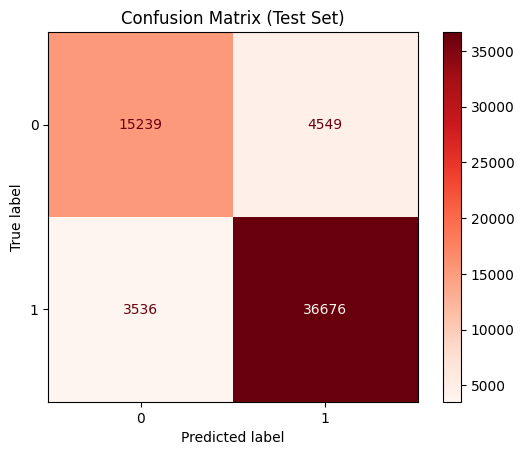

In [ ]:
# Generate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=nb_model.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix (Test Set)")

file_path = '/content/drive/MyDrive/Colab Notebooks/baseline_confusion.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

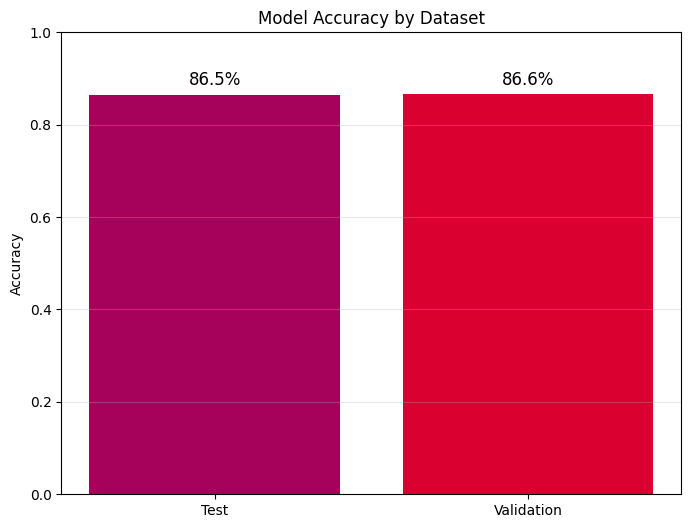

In [ ]:
# Accuracy values
accuracies = [test_accuracy, val_accuracy]
sets = ["Test", "Validation"]

rating_colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(sets, accuracies, color=['#A6025C', '#DA002F'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Dataset")
plt.ylim(0, 1)  # Ensure range is 0 to 1
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        height + 0.02,  # Y-coordinate (just above the bar)
        f"{height:.1%}",  # Format as percentage
        ha="center",  # Center text horizontally
        fontsize=12  # Adjust font size
    )

file_path = '/content/drive/MyDrive/Colab Notebooks/baseline_accuracy.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()


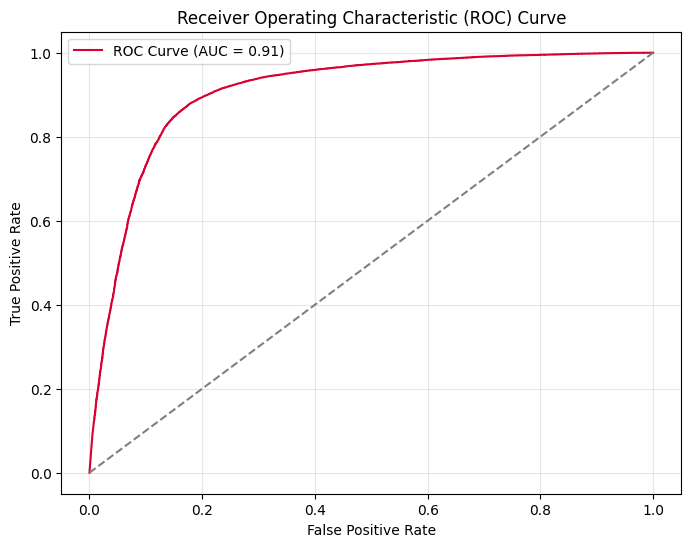

In [ ]:
# Predict probabilities for ROC curve
y_test_prob = nb_model.predict_proba(X_test_bow)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#DA002F', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(alpha=0.3)

file_path = '/content/drive/MyDrive/Colab Notebooks/baseline_ROC.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()


### Improved Models

#### Logistic Regression with TF-IDF

In [ ]:
# Logistic Regression with TF-IDF
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4000) # Both as per Qing Wang, Tianqi Wu paper (2019)

# Fit and transform the training data, and transform the test and validation data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the Logistic Regression model
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the test and validation sets
y_test_pred_lr = lr_model.predict(X_test_tfidf)
y_val_pred_lr = lr_model.predict(X_val_tfidf)


# Evaluate the model on the test set
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"Test Accuracy: {test_accuracy_lr:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_lr))

# Evaluate the model on the validation set
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
print(f"Validation Accuracy: {val_accuracy_lr:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_lr))

Test Accuracy: 0.9116

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     19788
           1       0.93      0.94      0.93     40212

    accuracy                           0.91     60000
   macro avg       0.90      0.89      0.90     60000
weighted avg       0.91      0.91      0.91     60000

Validation Accuracy: 0.9137

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     19714
           1       0.93      0.95      0.94     40286

    accuracy                           0.91     60000
   macro avg       0.91      0.90      0.90     60000
weighted avg       0.91      0.91      0.91     60000



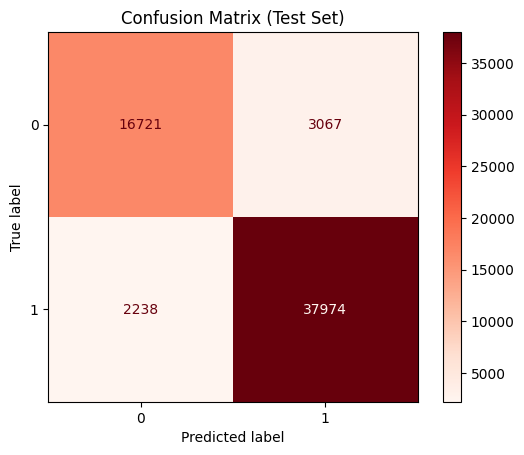

In [ ]:
# Generate confusion matrix for the test set
conf_matrix_lr = confusion_matrix(y_test, y_test_pred_lr)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=nb_model.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix (Test Set)")

file_path = '/content/drive/MyDrive/Colab Notebooks/Log_TFIDF_confusion.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

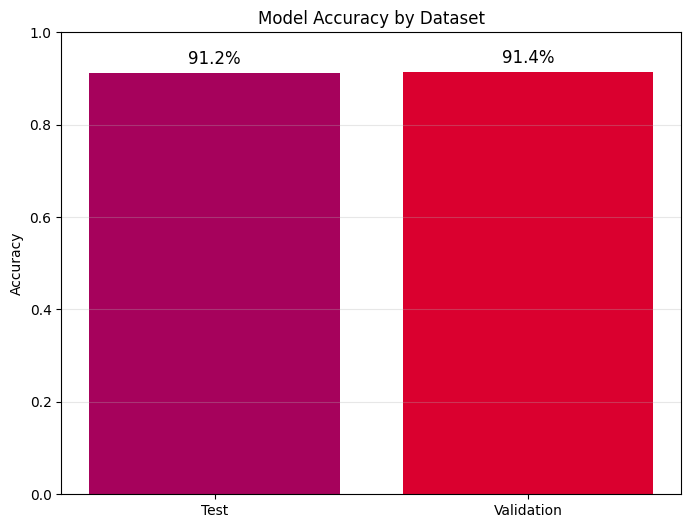

In [ ]:
# Accuracy values
accuracies_lr = [test_accuracy_lr, val_accuracy_lr]
sets = ["Test", "Validation"]

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(sets, accuracies_lr, color=['#A6025C', '#DA002F'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Dataset")
plt.ylim(0, 1)  # Ensure range is 0 to 1
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        height + 0.02,  # Y-coordinate (just above the bar)
        f"{height:.1%}",  # Format as percentage
        ha="center",  # Center text horizontally
        fontsize=12  # Adjust font size
    )

file_path = '/content/drive/MyDrive/Colab Notebooks/Log_TFIDF_accuracy.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

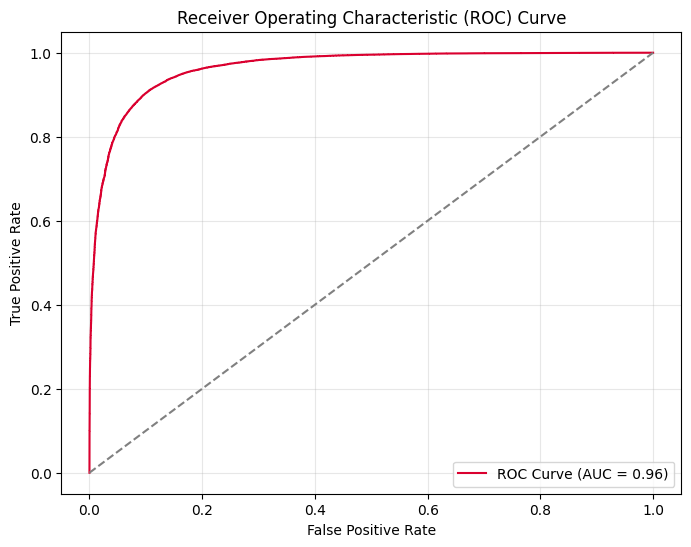

In [ ]:
# Predict probabilities for ROC curve
y_test_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]  # Probabilities for the positive class
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_test_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='#DA002F', label=f"ROC Curve (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(alpha=0.3)

file_path = '/content/drive/MyDrive/Colab Notebooks/Log_TFIDF_ROC.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### RNN with Word Embeddings

In [ ]:
# RNN with Word Embeddings
# Tokenize the text
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>") # As per Chen, W., Lu, X., Ling, Z., & Zhu, X. (2019)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Build the RNN model
embedding_dim = 50
model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN model
history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val), batch_size=64)

# Evaluate the RNN model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nRNN with Word Embeddings")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_test_pred_rnn = (model.predict(X_test_padded) > 0.5).astype("int32")
y_val_pred_rnn = (model.predict(X_val_padded) > 0.5).astype("int32")


# Evaluate the model on the test set
test_accuracy_rnn = accuracy_score(y_test, y_test_pred_rnn)
print(f"Test Accuracy: {test_accuracy_rnn:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_rnn))

# Evaluate the model on the validation set
val_accuracy_rnn = accuracy_score(y_val, y_val_pred_rnn)
print(f"Validation Accuracy: {val_accuracy_rnn:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_rnn))

Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.7675 - loss: 0.4835 - val_accuracy: 0.8991 - val_loss: 0.2491
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9005 - loss: 0.2564 - val_accuracy: 0.9016 - val_loss: 0.2407
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9124 - loss: 0.2270 - val_accuracy: 0.9161 - val_loss: 0.2138
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9223 - loss: 0.2019 - val_accuracy: 0.9165 - val_loss: 0.2103
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9283 - loss: 0.1873 - val_accuracy: 0.9197 - val_loss: 0.2025
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9342 - loss: 0.1740 - val_accuracy: 0.9170 - val_loss: 0.2062
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9395 - loss: 0.1598 - val_accuracy: 0.9191 - val_loss: 0.2060
Epoch 8/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9429 -

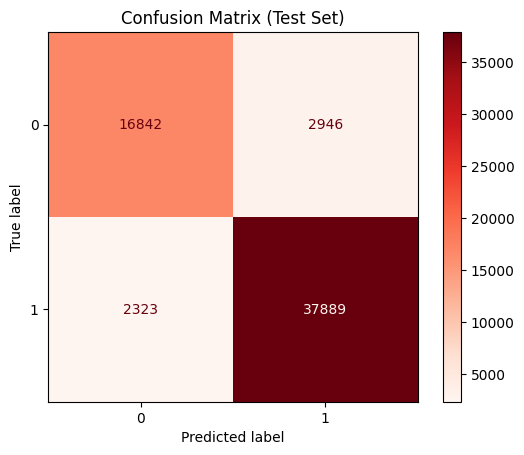

In [ ]:
# Generate confusion matrix for the test set
conf_matrix_rnn = confusion_matrix(y_test, y_test_pred_rnn)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rnn, display_labels=nb_model.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix (Test Set)")

file_path = '/content/drive/MyDrive/Colab Notebooks/RNN_confusion.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


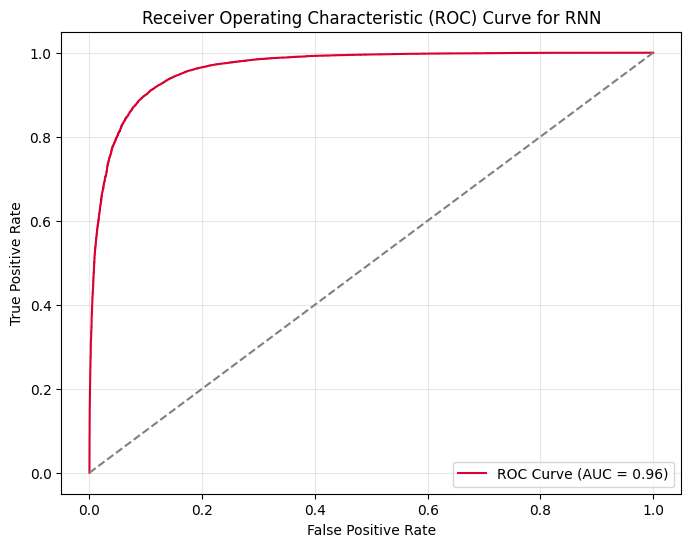

In [ ]:
# Predict probabilities for ROC curve
y_test_prob_rnn = model.predict(X_test_padded).flatten()
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test, y_test_prob_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

# Plot ROC curve for the RNN model
plt.figure(figsize=(8, 6))
plt.plot(fpr_rnn, tpr_rnn, color='#DA002F', label=f"ROC Curve (AUC = {roc_auc_rnn:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for RNN")
plt.legend()
plt.grid(alpha=0.3)

file_path = '/content/drive/MyDrive/Colab Notebooks/RNN_ROC.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

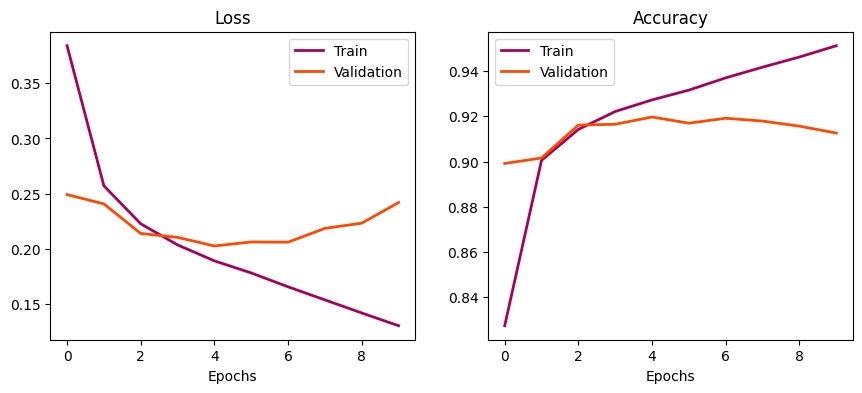

In [ ]:
# plot loss for train and validation

#rating_colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], lw=2, color='#A6025C')
plt.plot(history.history['val_loss'], lw=2, color='#FE4A00')
plt.legend(['Train', 'Validation'], fontsize=10)
# plt.ylim(0,1)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history.history['accuracy'], lw=2, color='#A6025C')
plt.plot(history.history['val_accuracy'], lw=2, color='#FE4A00')
plt.legend(['Train', 'Validation'], fontsize=10)
# plt.ylim(0,1)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

file_path = '/content/drive/MyDrive/Colab Notebooks/RNN_accuracy.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


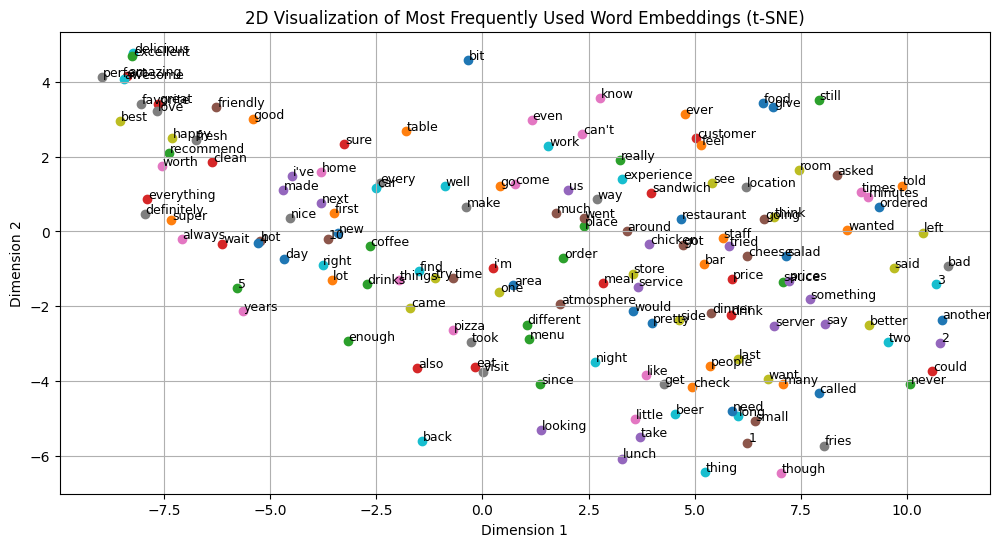

In [ ]:
# Most frequently used word embeddings
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Extract the embedding layer weights
embedding_layer = model.layers[0]  # Assuming the embedding layer is the first layer
embedding_weights = embedding_layer.get_weights()[0]

# Get the word-to-index mapping from the tokenizer
word_index = tokenizer.word_index

# Sort words by frequency (lower index = higher frequency)
sorted_word_index = sorted(word_index.items(), key=lambda x: x[1])  # Sort by index (frequency)

# Filter out stopwords and ensure indices are within the bounds of the embedding matrix
filtered_words_to_visualize = {
    word: index for word, index in sorted_word_index
    if index < embedding_weights.shape[0] and word not in stop_words and word != '<OOV>'
}

# Choose the most frequent words to visualize
num_words_to_visualize = 150
words_to_visualize = dict(list(filtered_words_to_visualize.items())[:num_words_to_visualize])

# Get the embeddings for the selected words
embeddings_to_visualize = np.array([embedding_weights[index] for index in words_to_visualize.values()])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_to_visualize)

# Plot the 2D embeddings
plt.figure(figsize=(12, 6))
for word, embedding in zip(words_to_visualize.keys(), embeddings_2d):
    x, y = embedding
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, word, fontsize=9)

plt.title("2D Visualization of Most Frequently Used Word Embeddings (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

#### CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout,
    SpatialDropout1D,
    LSTM,
    Bidirectional,
    BatchNormalization,
    Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

In [ ]:
# CNN model
# Parameters
vocab_size = 30000
embedding_dim = 300
max_length = 300

model = Sequential([
    # Embedding layer with spatial dropout
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.2),

    # Parallel convolutional layers
    Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    # Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),

    # Pooling layer
    GlobalMaxPooling1D(),

    # Dense layers with increasing dropout, to prevent overfitting
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Learning rate, with decay
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

# Add callbacks for better training.
callbacks = [
    ReduceLROnPlateau(    #If gradient descent gets stuck, decay the learning rate
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train with callbacks
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the CNN model
test_results = model.evaluate(X_test_padded, y_test)
print("\nCNN Metrics:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"{metric_name}: {value:.4f}")

# Make predictions
y_test_pred_cnn = (model.predict(X_test_padded) > 0.5).astype("int32")
y_val_pred_cnn = (model.predict(X_val_padded) > 0.5).astype("int32")

# Evaluate the model on the test set
test_accuracy_cnn = accuracy_score(y_test, y_test_pred_cnn)
print(f"\nTest Accuracy: {test_accuracy_cnn:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_cnn))

# Evaluate the model on the validation set
val_accuracy_cnn = accuracy_score(y_val, y_val_pred_cnn)
print(f"\nValidation Accuracy: {val_accuracy_cnn:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_cnn))

Epoch 1/10
5624/5625 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8121 - auc: 0.8671 - loss: 2.0301 - precision: 0.8544 - recall: 0.8644
Epoch 1: val_loss improved from inf to 0.33362, saving model to best_model.keras
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 219s 37ms/step - accuracy: 0.8122 - auc: 0.8671 - loss: 2.0297 - precision: 0.8544 - recall: 0.8644 - val_accuracy: 0.9049 - val_auc: 0.9683 - val_loss: 0.3336 - val_precision: 0.9590 - val_recall: 0.8966 - learning_rate: 0.0010
Epoch 2/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9145 - auc: 0.9603 - loss: 0.2985 - precision: 0.9282 - recall: 0.9458
Epoch 2: val_loss did not improve from 0.33362
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 205s 36ms/step - accuracy: 0.9145 - auc: 0.9603 - loss: 0.2985 - precision: 0.9282 - recall: 0.9458 - val_accuracy: 0.8670 - val_auc: 0.9696 - val_loss: 0.3894 - val_precision: 0.8381 - val_recall: 0.9939 - learning_rate: 0.0010
Epoch 3/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.926

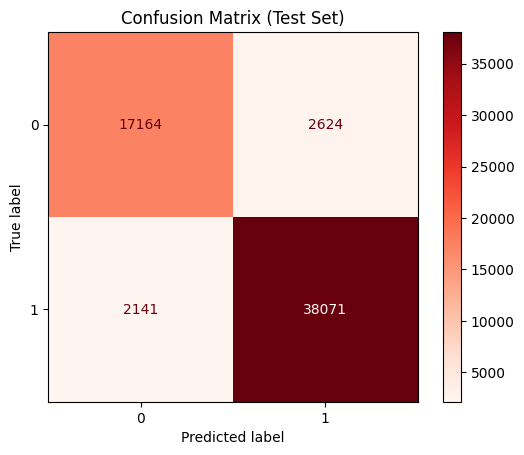

In [ ]:
# Generate confusion matrix for the test set
conf_matrix_cnn = confusion_matrix(y_test, y_test_pred_cnn)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cnn, display_labels=nb_model.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix (Test Set)")



file_path = '/content/drive/MyDrive/Colab Notebooks/CNN_confusion.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


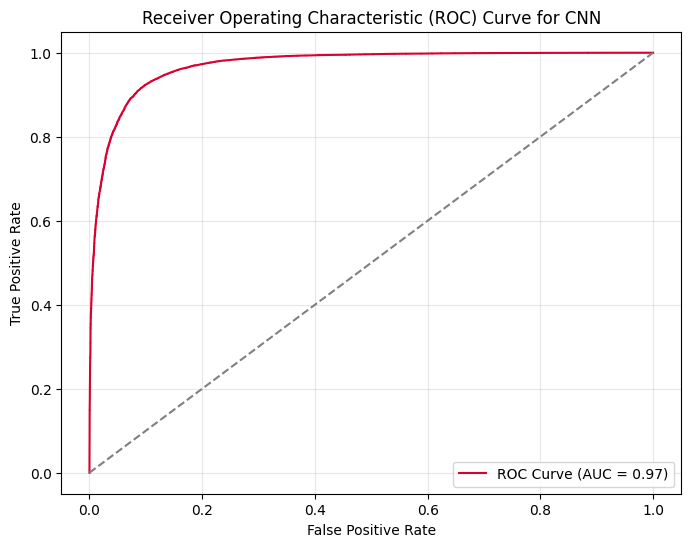

In [ ]:
# Predict probabilities for ROC curve
y_test_prob_cnn = model.predict(X_test_padded).flatten()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_test_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Plot ROC curve for the CNN model
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='#DA002F', label=f"ROC Curve (AUC = {roc_auc_cnn:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for CNN")
plt.legend()
plt.grid(alpha=0.3)

file_path = '/content/drive/MyDrive/Colab Notebooks/CNN_ROC.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

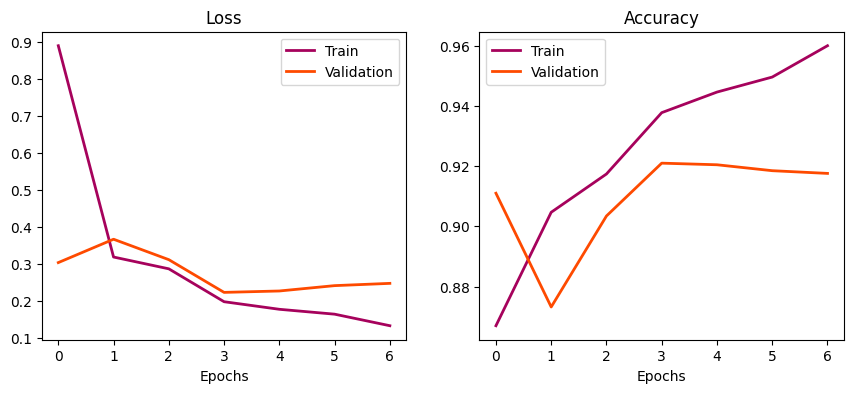

In [ ]:
# plot loss for train and validation

#rating_colors = ['#A6025C', '#DA002F', '#FE4A00', '#DE95C4', '#FF907A']

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], lw=2, color='#A6025C')
plt.plot(history.history['val_loss'], lw=2, color='#FE4A00')
plt.legend(['Train', 'Validation'], fontsize=10)
# plt.ylim(0,1)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history.history['accuracy'], lw=2, color='#A6025C')
plt.plot(history.history['val_accuracy'], lw=2, color='#FE4A00')
plt.legend(['Train', 'Validation'], fontsize=10)
# plt.ylim(0,1)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

file_path = '/content/drive/MyDrive/Colab Notebooks/CNN_accuracy.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### Transformer

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
max_length = 300
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Transformer Model
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

# Custom Transformer Block
from tensorflow.keras.layers import MultiHeadAttention

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # Add 'training' argument here
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define model parameters
vocab_size = 30000
embed_dim = 128  # Embedding size for each token
num_heads = 16   # Number of attention heads
ff_dim = 256     # Hidden layer size in feed forward network inside transformer

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs with no improvement to stop
    restore_best_weights=True # Restore weights from the epoch with the best performance
)

# Model architecture
inputs = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)  # Transformer block output (shape: (None, max_length, embed_dim))
x = transformer_block(x)  # Transformer block output (shape: (None, max_length, embed_dim))

# Apply pooling to get a single prediction for each sequence
x = GlobalAveragePooling1D()(x)  # Now the shape becomes (None, embed_dim)

# Output layer for binary classification
x = Dense(256, activation="relu")(x)

# Output layer for binary classification
x = Dense(128, activation="relu")(x)

# Output layer for binary classification
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the Transformer model
history = model.fit(X_train_padded, y_train, epochs=6, validation_data=(X_val_padded, y_val), batch_size=256, callbacks=[early_stopping])

# Evaluate the Transformer model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTransformer Model")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_test_pred_trans = (model.predict(X_test_padded) > 0.5).astype("int32")
y_val_pred_trans = (model.predict(X_val_padded) > 0.5).astype("int32")

# Evaluate the model on the test set
test_accuracy_trans = accuracy_score(y_test, y_test_pred_trans)
print(f"Test Accuracy: {test_accuracy_trans:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_trans))

# Evaluate the model on the validation set
val_accuracy_trans = accuracy_score(y_val, y_val_pred_trans)
print(f"Validation Accuracy: {val_accuracy_trans:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_trans))

Epoch 1/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 409s 538ms/step - accuracy: 0.8070 - loss: 0.4098 - val_accuracy: 0.9163 - val_loss: 0.2094
Epoch 2/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 352s 500ms/step - accuracy: 0.9238 - loss: 0.1974 - val_accuracy: 0.9153 - val_loss: 0.2223
Epoch 3/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 352s 500ms/step - accuracy: 0.9357 - loss: 0.1662 - val_accuracy: 0.9038 - val_loss: 0.2471
Epoch 4/6
704/704 ━━━━━━━━━━━━━━━━━━━━ 352s 500ms/step - accuracy: 0.9460 - loss: 0.1432 - val_accuracy: 0.9024 - val_loss: 0.2940
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.9148 - loss: 0.2121

Transformer Model
Test Accuracy: 0.9143
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step
Test Accuracy: 0.9143

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     19788
           1       0.92      0.96      0.94     40212

    accuracy                           0.91     600

### Transformer w/o 3 start review

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
max_length = 300
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Transformer Model
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

# Custom Transformer Block
from tensorflow.keras.layers import MultiHeadAttention

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # Add 'training' argument here
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define model parameters
vocab_size = 30000
embed_dim = 128  # Embedding size for each token
num_heads = 16   # Number of attention heads
ff_dim = 256     # Hidden layer size in feed forward network inside transformer

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs with no improvement to stop
    restore_best_weights=True # Restore weights from the epoch with the best performance
)

# Model architecture
inputs = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)  # Transformer block output (shape: (None, max_length, embed_dim))
x = transformer_block(x)  # Transformer block output (shape: (None, max_length, embed_dim))

# Apply pooling to get a single prediction for each sequence
x = GlobalAveragePooling1D()(x)  # Now the shape becomes (None, embed_dim)

# Output layer for binary classification
x = Dense(256, activation="relu")(x)

# Output layer for binary classification
x = Dense(128, activation="relu")(x)

# Output layer for binary classification
x = Dense(1, activation="sigmoid")(x)

# Create the model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the Transformer model
history = model.fit(X_train_padded, y_train, epochs=6, validation_data=(X_val_padded, y_val), batch_size=256, callbacks=[early_stopping])

# Evaluate the Transformer model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTransformer Model")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_test_pred_trans = (model.predict(X_test_padded) > 0.5).astype("int32")
y_val_pred_trans = (model.predict(X_val_padded) > 0.5).astype("int32")

# Evaluate the model on the test set
test_accuracy_trans = accuracy_score(y_test, y_test_pred_trans)
print(f"Test Accuracy: {test_accuracy_trans:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_trans))

# Evaluate the model on the validation set
val_accuracy_trans = accuracy_score(y_val, y_val_pred_trans)
print(f"Validation Accuracy: {val_accuracy_trans:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_trans))

Epoch 1/6
634/634 ━━━━━━━━━━━━━━━━━━━━ 372s 567ms/step - accuracy: 0.8220 - loss: 0.4036 - val_accuracy: 0.9572 - val_loss: 0.1175
Epoch 2/6
634/634 ━━━━━━━━━━━━━━━━━━━━ 317s 500ms/step - accuracy: 0.9656 - loss: 0.0957 - val_accuracy: 0.9551 - val_loss: 0.1142
Epoch 3/6
634/634 ━━━━━━━━━━━━━━━━━━━━ 317s 500ms/step - accuracy: 0.9726 - loss: 0.0737 - val_accuracy: 0.9577 - val_loss: 0.1345
Epoch 4/6
634/634 ━━━━━━━━━━━━━━━━━━━━ 317s 500ms/step - accuracy: 0.9776 - loss: 0.0585 - val_accuracy: 0.9552 - val_loss: 0.1473
Epoch 5/6
634/634 ━━━━━━━━━━━━━━━━━━━━ 317s 500ms/step - accuracy: 0.9814 - loss: 0.0467 - val_accuracy: 0.9533 - val_loss: 0.1604
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.9540 - loss: 0.1166

Transformer Model
Test Accuracy: 0.9547
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step
1690/1690 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step
Test Accuracy: 0.9547

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      

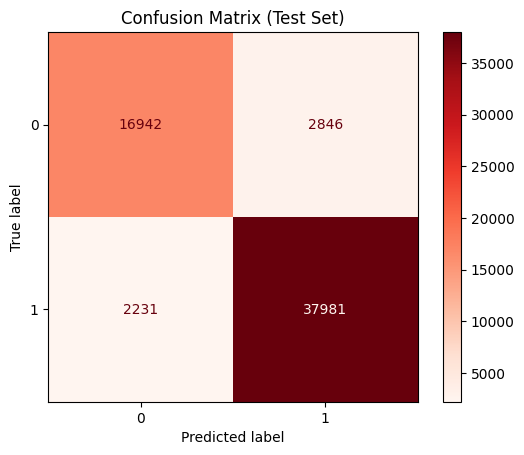

In [ ]:
# Generate confusion matrix for the test set
conf_matrix_trans = confusion_matrix(y_test, y_test_pred_trans)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_trans, display_labels=nb_model.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix (Test Set)")



#file_path = '/content/drive/MyDrive/Colab Notebooks/CNN_confusion.png'
#plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


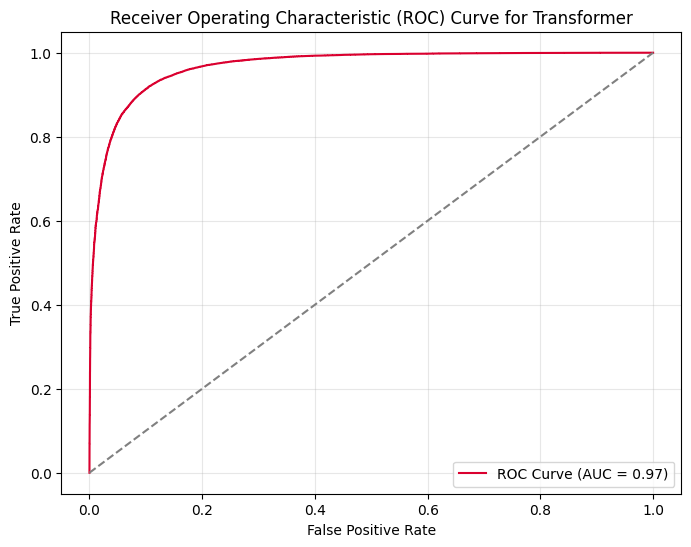

In [ ]:
# Predict probabilities for ROC curve
y_test_prob_trans = model.predict(X_test_padded).flatten()
fpr_trans, tpr_trans, thresholds_trans = roc_curve(y_test, y_test_prob_trans)
roc_auc_trans = auc(fpr_trans, tpr_trans)

# Plot ROC curve for the Transformer model
plt.figure(figsize=(8, 6))
plt.plot(fpr_trans, tpr_trans, color='#DA002F', label=f"ROC Curve (AUC = {roc_auc_trans:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Transformer")
plt.legend()
plt.grid(alpha=0.3)

#file_path = '/content/drive/MyDrive/Colab Notebooks/CNN_ROC.png'
#plt.savefig(file_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

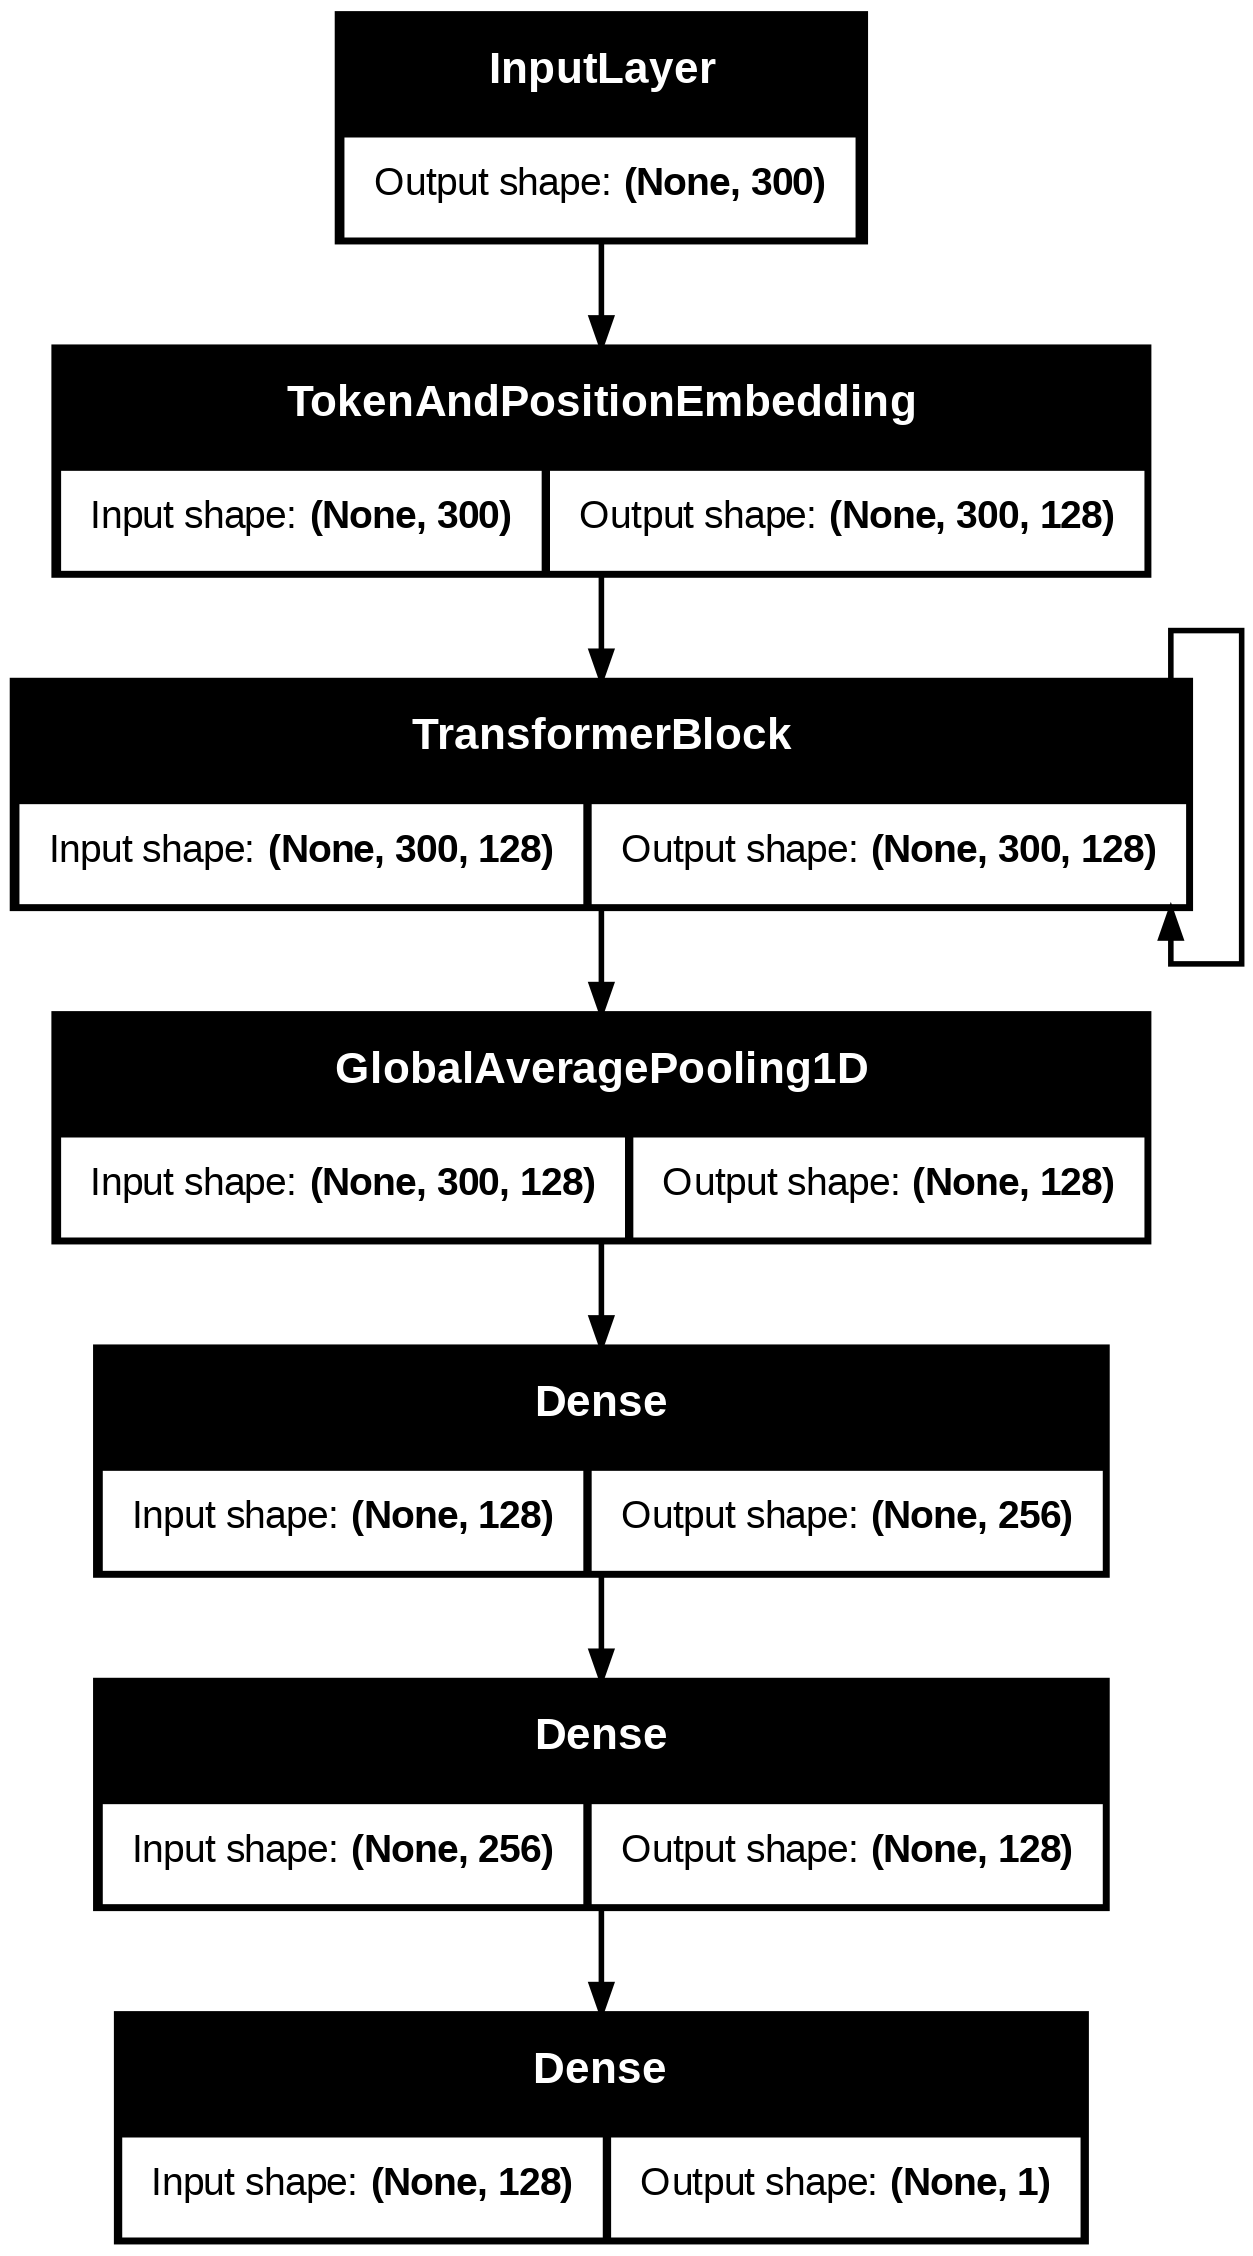

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
explainer = LimeTextExplainer(class_names=["negative", "positive"])

def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_length)
    return np.array([[float(1 - x), float(x)]
                     for x in model.predict(np.array(_seq_pad))])

text_id = 10

model_predict_pipeline(X_val[[text_id]])

## correct label
y_val[text_id]

exp = explainer.explain_instance(X_val[text_id],
                                 model_predict_pipeline,
                                 num_features=10,
                                 top_labels=1)

exp.show_in_notebook(text=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


#### Transformer Fine Tuning

In [ ]:
# Define search grid
embed_dim_options = [8, 16]
num_heads_options = [4, 8]
ff_dim_options = [16, 32]
learning_rate_options = [0.001, 0.0005]
batch_size_options = [256, 512]
dropout_rate_options = [0.1, 0.2]

# Grid search over all combinations
param_grid = list(product(embed_dim_options, num_heads_options, ff_dim_options, learning_rate_options, batch_size_options, dropout_rate_options))

best_val_accuracy = 0
best_params = None

for embed_dim, num_heads, ff_dim, lr, batch_size, dropout_rate in param_grid:
    # Build and compile the model with current parameters
    inputs = Input(shape=(max_length,))
    embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
    x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    # Compile with dynamic learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
        X_train_padded, y_train,
        epochs=6,
        validation_data=(X_val_padded, y_val),
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0  # Suppress detailed output
    )

    # Evaluate validation accuracy
    val_accuracy = max(history.history["val_accuracy"])

    print(f"Params: embed_dim={embed_dim}, num_heads={num_heads}, ff_dim={ff_dim}, lr={lr}, batch_size={batch_size}, dropout_rate={dropout_rate}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Update best parameters if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = (embed_dim, num_heads, ff_dim, lr, batch_size, dropout_rate)

print("\nBest Parameters:")
print(f"embed_dim={best_params[0]}, num_heads={best_params[1]}, ff_dim={best_params[2]}, lr={best_params[3]}, batch_size={best_params[4]}, dropout_rate={best_params[5]}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.001, batch_size=256, dropout_rate=0.1
Validation Accuracy: 0.9167
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.001, batch_size=256, dropout_rate=0.2
Validation Accuracy: 0.9172
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.001, batch_size=512, dropout_rate=0.1
Validation Accuracy: 0.9161
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.001, batch_size=512, dropout_rate=0.2
Validation Accuracy: 0.9177
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.0005, batch_size=256, dropout_rate=0.1
Validation Accuracy: 0.9143
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.0005, batch_size=256, dropout_rate=0.2
Validation Accuracy: 0.9170
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.0005, batch_size=512, dropout_rate=0.1
Validation Accuracy: 0.9114
Params: embed_dim=8, num_heads=4, ff_dim=16, lr=0.0005, batch_size=512, dropout_rate=0.2
Validation Accuracy: 0.9133
Params: embed_dim=8, num_heads=4, ff_dim=32, lr=0.001, batch_size=25